## Importing libraries

In [18]:
# Standard library imports
import os
import sys
import json
import random

# Third-party library imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Google Colab specific imports
from google.colab import drive

# Set the working directory
DIR_DATA = '/content/'
os.chdir(DIR_DATA)


# Datasets

In [9]:
class CIFAR100Dataset(Dataset):
    def __init__(self, root, split='train', transform=None, sharding=None, K=10, Nc=2):
        """
        CIFAR-100 Dataset with IID and non-IID sharding.

        Args:
        - root (str): Directory to store the dataset.
        - split (str): 'train' or 'test'.
        - transform (callable): Transformations applied to the images.
        - sharding (str): 'iid' or 'niid'.
        - K (int): Number of clients for the sharding.
        - Nc (int): Number of classes per client (used for non-iid sharding).
        """
        self.root = root
        self.split = split
        self.transform = transform
        self.sharding = sharding
        self.K = K
        self.Nc = Nc

        # Default transformations if none are provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        dataset = datasets.CIFAR100(
            root=self.root,
            train=(self.split == 'train'),
            download=True
        )

        self.data = pd.DataFrame({
            "image": [dataset[i][0] for i in range(len(dataset))],
            "label": [dataset[i][1] for i in range(len(dataset))]
        })

        if self.split == 'train' and self.sharding:
            self.data = self._apply_sharding()

    def _apply_sharding(self):
        """Apply IID or non-IID sharding to the training data."""
        if self.sharding == 'iid':
            return self._iid_sharding()
        elif self.sharding == 'niid':
            return self._non_iid_sharding()
        else:
            raise ValueError("Sharding must be 'iid' or 'niid'.")

    def _iid_sharding(self):
        """Split data IID: uniformly distribute samples across K clients."""
        data_split = []
        indices = self.data.index.tolist()
        random.shuffle(indices)

        # Split indices equally among K clients
        client_indices = [indices[i::self.K] for i in range(self.K)]

        for client_id, idxs in enumerate(client_indices):
            client_data = self.data.loc[idxs].copy()
            client_data['client_id'] = client_id
            data_split.append(client_data)

        return pd.concat(data_split, ignore_index=True)

    def _non_iid_sharding(self):
        """Split data non-IID: assign Nc classes per client."""
        data_split = []
        unique_classes = self.data['label'].unique()
        random.shuffle(unique_classes)

        # Divide classes into groups of Nc
        class_groups = [unique_classes[i:i + self.Nc] for i in range(0, len(unique_classes), self.Nc)]
        class_groups = class_groups[:self.K]  # Limit to K clients

        for client_id, class_group in enumerate(class_groups):
            client_data = self.data[self.data['label'].isin(class_group)].copy()
            client_data['client_id'] = client_id

            # Ensure approximately equal samples per client
            client_data = client_data.sample(n=len(self.data) // self.K, replace=True, random_state=42)
            data_split.append(client_data)

        return pd.concat(data_split, ignore_index=True)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image, label = row['image'], row['label']

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)


# Centralized training of CIFAR100

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Step the scheduler
        if scheduler is not None:
          scheduler.step()

        # Evaluate on test set
        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
        train_losses.append(epoch_loss / len(train_loader))
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, test_losses, test_accuracies

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    return total_loss / len(test_loader), correct / total


In [ ]:
BATCH_SIZE = 96
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
EPOCHS = 50

train_dataset_big = CIFAR100Dataset(DIR_DATA, split='train')
test_dataset = CIFAR100Dataset(DIR_DATA, split='test')

indexes = range(0, len(train_dataset_big))
splitting = train_test_split(indexes, train_size = 0.8, random_state = 42, stratify = train_dataset_big.data["label"], shuffle = True)
train_indexes = splitting[0]
val_indexes = splitting[1]

train_dataset = Subset(train_dataset_big, train_indexes)
val_dataset = Subset(train_dataset_big, val_indexes)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model_cifar = models.resnet18(pretrained=False, num_classes=100)


optimizer_cifar = optim.SGD(model_cifar.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

scheduler_cifar = CosineAnnealingLR(optimizer_cifar, T_max=200)

criterion = nn.CrossEntropyLoss()


train_losses_cifar, test_losses_cifar, test_accuracies_cifar = train_model(
    model=model_cifar,
    train_loader = train_dataloader,
    test_loader = test_dataloader,
    optimizer=optimizer_cifar,
    scheduler=scheduler_cifar,
    criterion=criterion,
    epochs=50
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(test_losses_cifar, label='CIFAR-100 Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies_cifar, label='CIFAR-100 Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## First FL Baselines

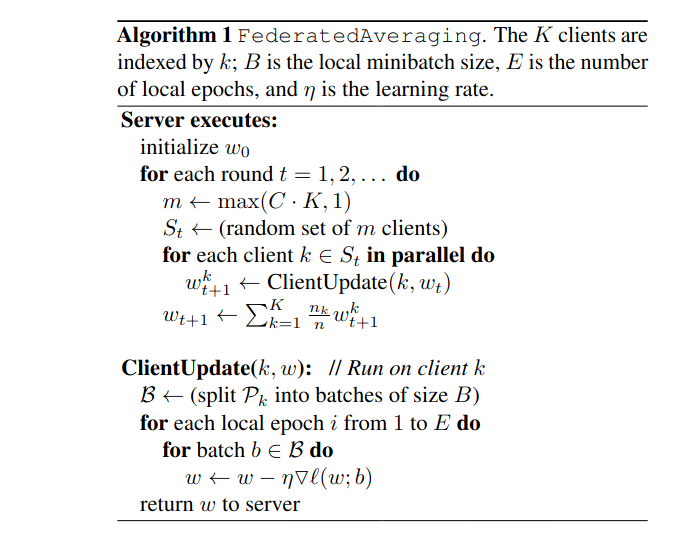

In [30]:
def federated_averaging(model, data, epochs, batch_size, num_rounds, fraction_fit, clients):

  # data is the CIFAR100 dataset, TODO: implement the splitting into k clients
  # goal is data is indexed with data[k]

  for round in range(num_rounds):
    print(f"Round {round+1}/{num_rounds}")
    m = max(int(fraction_fit * clients), 1)
    selected_clients = np.random.choice([i for i in range(clients)], m, replace=False)

    global_weights = model.state_dict()

    client_weights = []
    for client in selected_clients:
      client_weights.append(client_training())

    # Perform weighted averaging of client models
    # TODO
    new_global_weights = [np.zeros_like(w) for w in global_weights]
    total_data_size = sum([len(data[client]) for client in selected_clients])

    # Update global model weights
    model.load_state_dict(new_global_weights)

    # Evaluate global model
           # loss, accuracy = self.global_model.evaluate(self.test_data[0], self.test_data[1], verbose=0)
           # self.rounds_loss.append(loss)
           # self.rounds_accuracy.append(accuracy)
           # print(f"Round {round+1}/{num_rounds} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

def client_training(data, client, weights, epochs, batch_size):

  data = data[client]
  local_trainloader = DataLoader(data, batch_size=batch_size, shuffle=True)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  for epoch in range(epochs):
    for batch_idx, (inputs, targets) in enumerate(local_trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
  return weights


